In [1]:
import sys
import os
import numpy as np
import seaborn as sns
import optuna
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from Utils.data_utils import load_preprocessed_data_from_folder



In [2]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.502784,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.602571,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.563298,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.560356,0.434710,0.215044,0.535173,0.515598,0.341800,0.578386,0.497830,0.644700,1.0
3992,0.369342,0.453484,0.419993,0.555453,0.659636,0.310077,0.418230,0.518917,0.459890,1.0
3993,0.514873,0.394047,0.550464,0.706030,0.415335,0.544953,0.446907,0.582838,0.610959,1.0
3994,0.500670,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [3]:
# naive model

In [4]:
TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 1884  0.506304  0.454338  0.411750     0.515790  0.642708      0.204925   
 3577  0.562297  0.566637  0.379275     0.523370  0.558312      0.236210   
 3258  0.474172  0.483854  0.155182     0.621838  0.593353      0.384059   
 1992  0.452682  0.299070  0.140971     0.506920  0.564018      0.601094   
 742   0.548498  0.573277  0.117419     0.534628  0.638220      0.373785   
 ...        ...       ...       ...          ...       ...           ...   
 502   0.383396  0.464289  0.471020     0.479800  0.575277      0.493119   
 2129  0.492314  0.556447  0.335309     0.513032  0.385317      0.470182   
 1824  0.498623  0.555095  0.501457     0.457478  0.746148      0.421443   
 918   0.484580  0.515707  0.203853     0.437086  0.630800      0.522550   
 2522  0.653735  0.660550  0.397985     0.523705  0.692254      0.374079   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 1884        0.438229 

In [5]:
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [6]:
oModel = SVC()
oModel.fit(train_x, train_y)

print(f'SVC test accuracy: {oModel.score(test_x, test_y):0.2%}')

SVC test accuracy: 69.00%


In [7]:
naive_predictions = oModel.predict(test_x)

In [8]:
naive_accuracy = accuracy_score(test_y, naive_predictions)
naive_f1 = f1_score(test_y, naive_predictions)
naive_precision = precision_score(test_y, naive_predictions)
naive_recall = recall_score(test_y, naive_predictions)
print(f"Naive Model Performance:")
print(f"Accuracy: {naive_accuracy:.2f}")
print(f"F1 Score: {naive_f1:.2f}")
print(f"Precision: {naive_precision:.2f}")
print(f"Recall: {naive_recall:.2f}")

Naive Model Performance:
Accuracy: 0.69
F1 Score: 0.69
Precision: 0.73
Recall: 0.65


In [9]:
# optuna

In [12]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 1, 3)
    classifier = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)
    scores = cross_val_score(classifier, train_x, train_y, cv=NUM_FOLDS, scoring='f1')
    return np.mean(scores)

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-04-19 11:49:43,271] A new study created in memory with name: no-name-a5172490-bd68-4cf2-9cac-7ec79804969d
[I 2024-04-19 11:49:48,213] Trial 0 finished with value: 0.7121585020800844 and parameters: {'C': 383.7235350252813, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7121585020800844.
[I 2024-04-19 11:49:54,538] Trial 1 finished with value: 0.7114135355484195 and parameters: {'C': 657.6977020928545, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7121585020800844.
[I 2024-04-19 11:49:55,748] Trial 2 finished with value: 0.3917375962851638 and parameters: {'C': 816.0585334422241, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.7121585020800844.
[I 2024-04-19 11:49:57,119] Trial 3 finished with value: 0.6128738180073982 and parameters: {'C': 759.418998559506, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7121585020800844.
[I 2024-04-19 11:49:58,144] Trial 4 finished with value: 0.0 and parameters: {'C'

C:\Users\yuval.yarom\AppData\Local\Temp\ipykernel_31636\1791146102.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


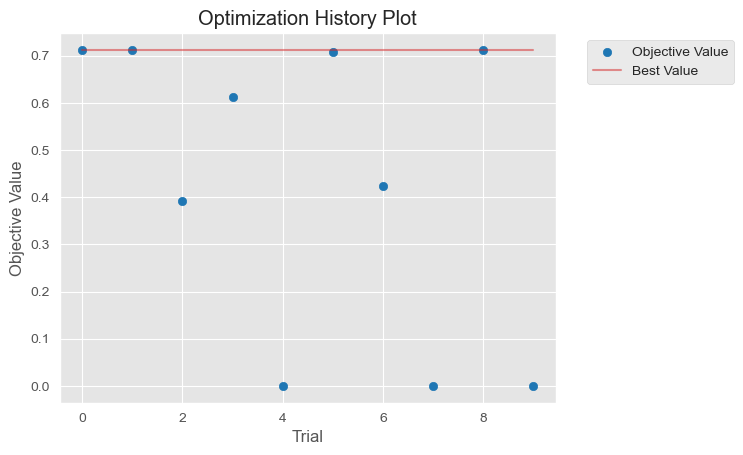

In [14]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

C:\Users\yuval.yarom\AppData\Local\Temp\ipykernel_31636\2472360306.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


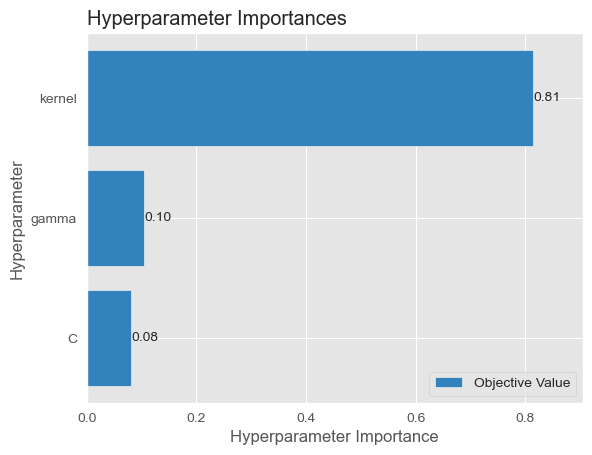

In [15]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

C:\Users\yuval.yarom\AppData\Local\Temp\ipykernel_31636\2254680547.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


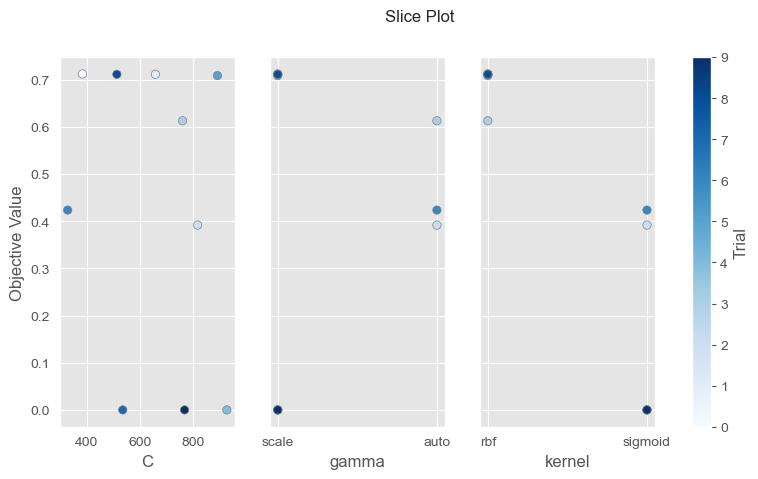

In [16]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

C:\Users\yuval.yarom\AppData\Local\Temp\ipykernel_31636\4137338307.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-04-19 11:52:52,079] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


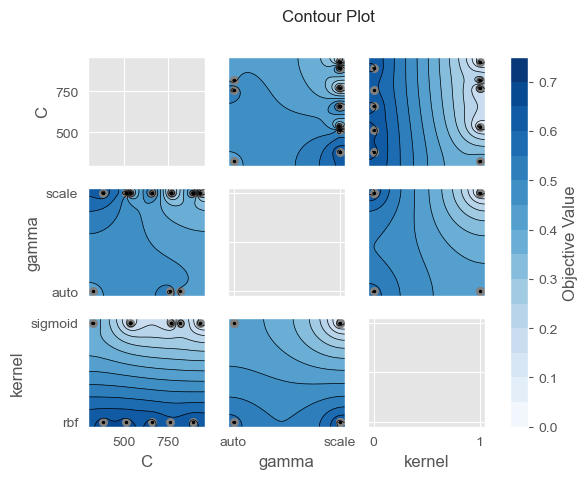

In [17]:
optuna.visualization.matplotlib.plot_contour(study)
plt.show()

In [18]:
# cross_validation

In [19]:
vC = [0.001, 0.01, 0.1, 1, 10]
vGamma = ['scale', 'auto']
param_grid = [
    {'kernel': ['poly'], 'C': vC, 'degree': [2, 3], 'gamma': vGamma},
    {'kernel': ['rbf'], 'C': vC, 'gamma': vGamma},
    {'kernel': ['sigmoid'], 'C': vC, 'gamma': vGamma, },
]

grid_search = GridSearchCV(SVC(), param_grid, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

print(f'SVC test accuracy: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC test accuracy: 73.27%


In [20]:
best_model = grid_search.best_estimator_
print(f'Best model: {best_model}, best params: {grid_search.best_params_}')

print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: SVC(C=10), best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best model score: 72.00%


In [21]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 0.0001
end for C = 0.0001
start for C = 0.0005
end for C = 0.0005
start for C = 0.001
end for C = 0.001
start for C = 0.005
end for C = 0.005
start for C = 0.01
end for C = 0.01
start for C = 0.05
end for C = 0.05
start for C = 0.1
end for C = 0.1
start for C = 0.5
end for C = 0.5
start for C = 1
end for C = 1
start for C = 5
end for C = 5
start for C = 10
end for C = 10
start for C = 50
end for C = 50
start for C = 100
end for C = 100
start for C = 500
end for C = 500
start for C = 1000
end for C = 1000


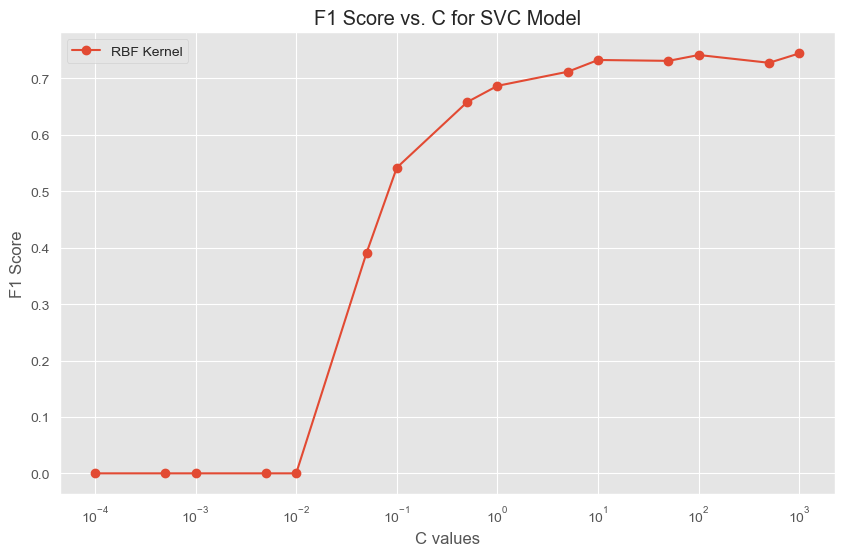

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
C_values = np.linspace(0.1, 10000, 15)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 0.1
end for C = 0.1
start for C = 714.3785714285714
end for C = 714.3785714285714
start for C = 1428.6571428571426
end for C = 1428.6571428571426
start for C = 2142.935714285714
end for C = 2142.935714285714
start for C = 2857.2142857142853
end for C = 2857.2142857142853
start for C = 3571.492857142857
end for C = 3571.492857142857
start for C = 4285.771428571428
end for C = 4285.771428571428
start for C = 5000.05
end for C = 5000.05
start for C = 5714.328571428571
end for C = 5714.328571428571
start for C = 6428.607142857142
end for C = 6428.607142857142
start for C = 7142.885714285714
end for C = 7142.885714285714
start for C = 7857.164285714285
end for C = 7857.164285714285
start for C = 8571.442857142856
end for C = 8571.442857142856
start for C = 9285.721428571427
end for C = 9285.721428571427
start for C = 10000.0
end for C = 10000.0


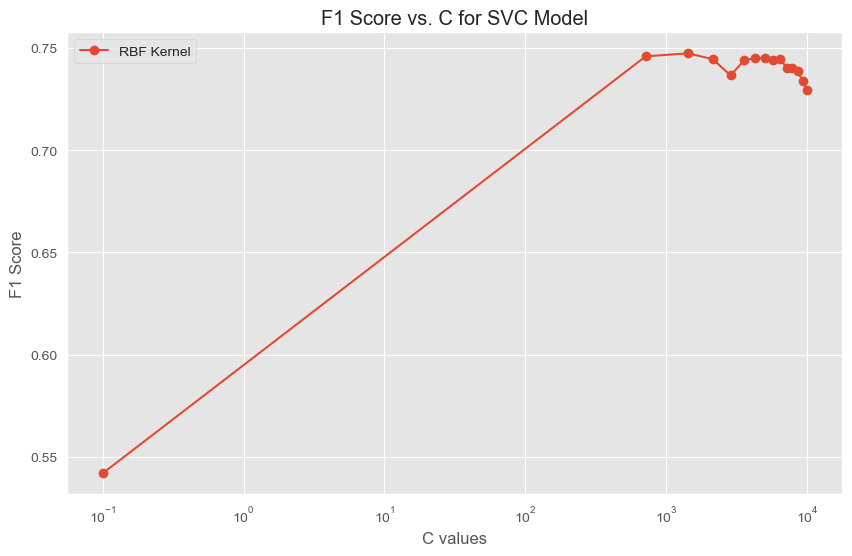

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
C_values = np.linspace(600, 900, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 600.0
end for C = 600.0
start for C = 633.3333333333334
end for C = 633.3333333333334
start for C = 666.6666666666666
end for C = 666.6666666666666
start for C = 700.0
end for C = 700.0
start for C = 733.3333333333334
end for C = 733.3333333333334
start for C = 766.6666666666667
end for C = 766.6666666666667
start for C = 800.0
end for C = 800.0
start for C = 833.3333333333334
end for C = 833.3333333333334
start for C = 866.6666666666667
end for C = 866.6666666666667
start for C = 900.0
end for C = 900.0


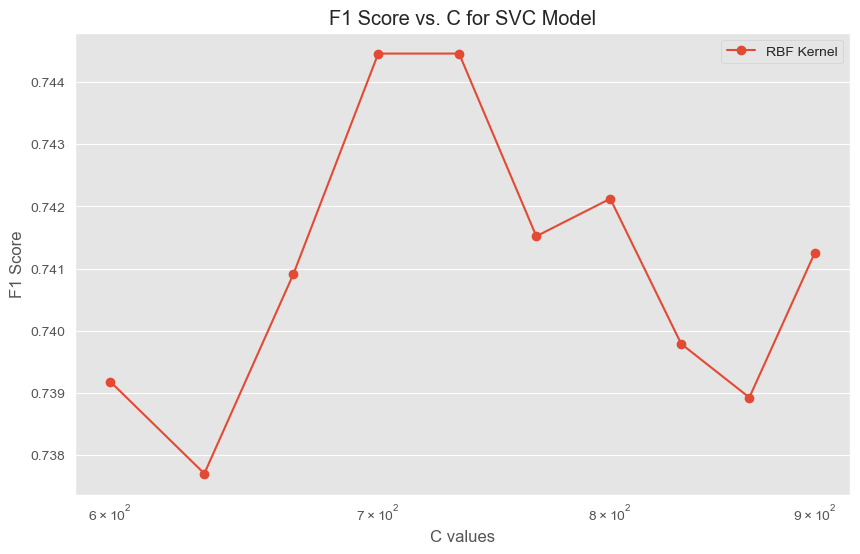

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
C_values = np.linspace(650, 720, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 650.0
end for C = 650.0
start for C = 657.7777777777778
end for C = 657.7777777777778
start for C = 665.5555555555555
end for C = 665.5555555555555
start for C = 673.3333333333334
end for C = 673.3333333333334
start for C = 681.1111111111111
end for C = 681.1111111111111
start for C = 688.8888888888889
end for C = 688.8888888888889
start for C = 696.6666666666666
end for C = 696.6666666666666
start for C = 704.4444444444445
end for C = 704.4444444444445
start for C = 712.2222222222222
end for C = 712.2222222222222
start for C = 720.0
end for C = 720.0


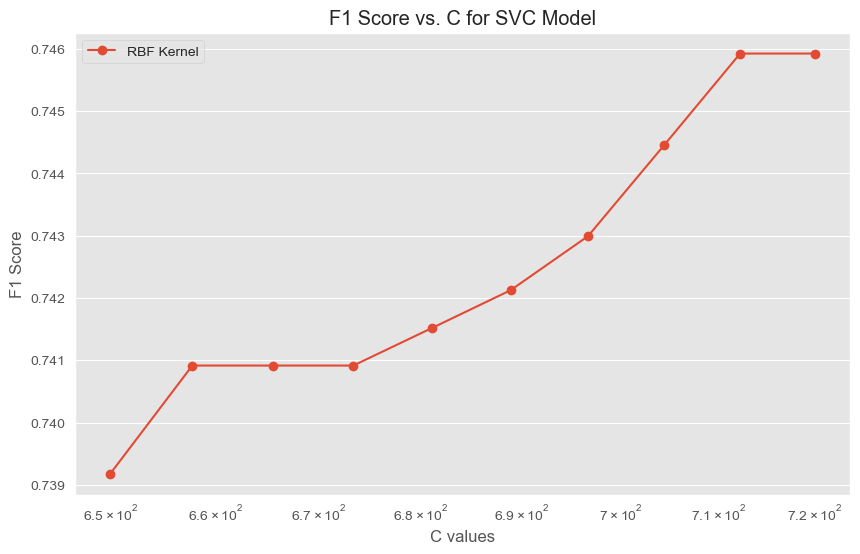

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
C_values = np.linspace(700, 715, 15)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 700.0
end for C = 700.0
start for C = 701.0714285714286
end for C = 701.0714285714286
start for C = 702.1428571428571
end for C = 702.1428571428571
start for C = 703.2142857142857
end for C = 703.2142857142857
start for C = 704.2857142857143
end for C = 704.2857142857143
start for C = 705.3571428571429
end for C = 705.3571428571429
start for C = 706.4285714285714
end for C = 706.4285714285714
start for C = 707.5
end for C = 707.5
start for C = 708.5714285714286
end for C = 708.5714285714286
start for C = 709.6428571428571
end for C = 709.6428571428571
start for C = 710.7142857142857
end for C = 710.7142857142857
start for C = 711.7857142857143
end for C = 711.7857142857143
start for C = 712.8571428571429
end for C = 712.8571428571429
start for C = 713.9285714285714
end for C = 713.9285714285714
start for C = 715.0
end for C = 715.0


end for C = 715.0


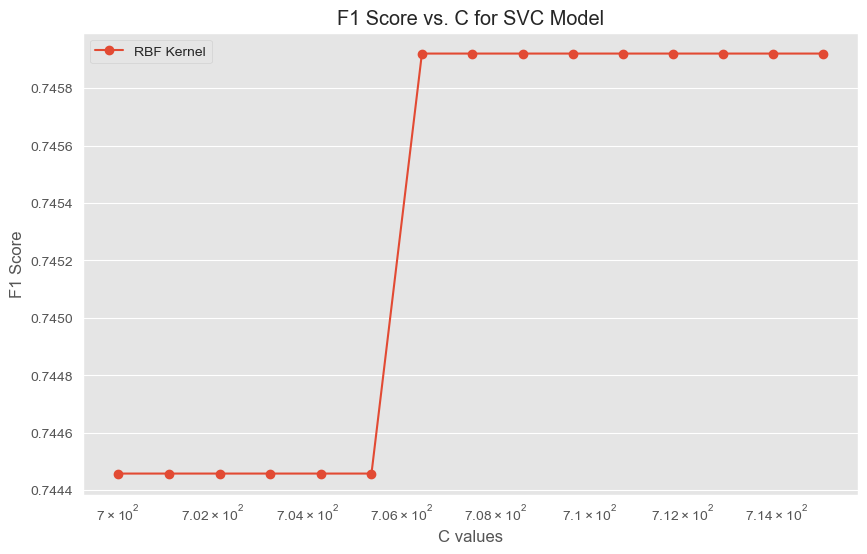

In [31]:
    print(f'end for C = {C}')
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
ideal_svc = SVC(kernel=grid_search.best_params_['kernel'], C=707,gamma=grid_search.best_params_['gamma'])
ideal_svc.fit(train_x, train_y)
ideal_y_pred = ideal_svc.predict(test_x)

In [33]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(test_y, ideal_y_pred)

print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.7275


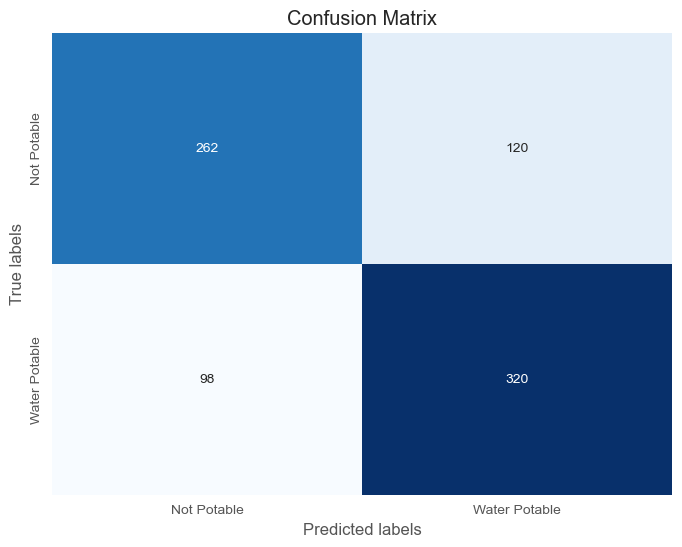

In [34]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, ideal_y_pred,labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
calibrated_svc = CalibratedClassifierCV(ideal_svc, cv=NUM_FOLDS)
calibrated_svc.fit(train_x, train_y)

print(f'Calibrated SVC test accuracy: {calibrated_svc.score(test_x, test_y):0.2%}')

Calibrated SVC test accuracy: 72.12%


In [36]:
calibrated_svc.predict_proba(test_x)

array([[0.20045529, 0.79954471],
       [0.80928429, 0.19071571],
       [0.17400629, 0.82599371],
       ...,
       [0.08799145, 0.91200855],
       [0.42946774, 0.57053226],
       [0.40098555, 0.59901445]])

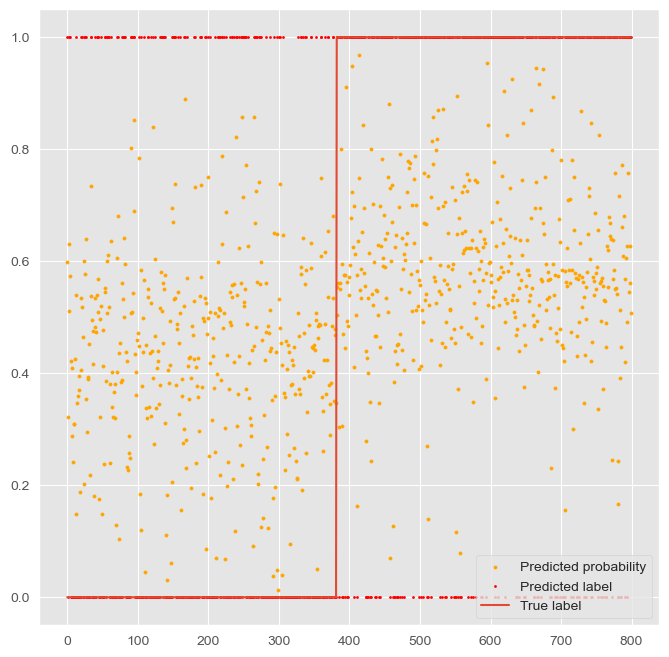

In [37]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_svc.predict_proba(test_x)[:, 1], calibrated_svc.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

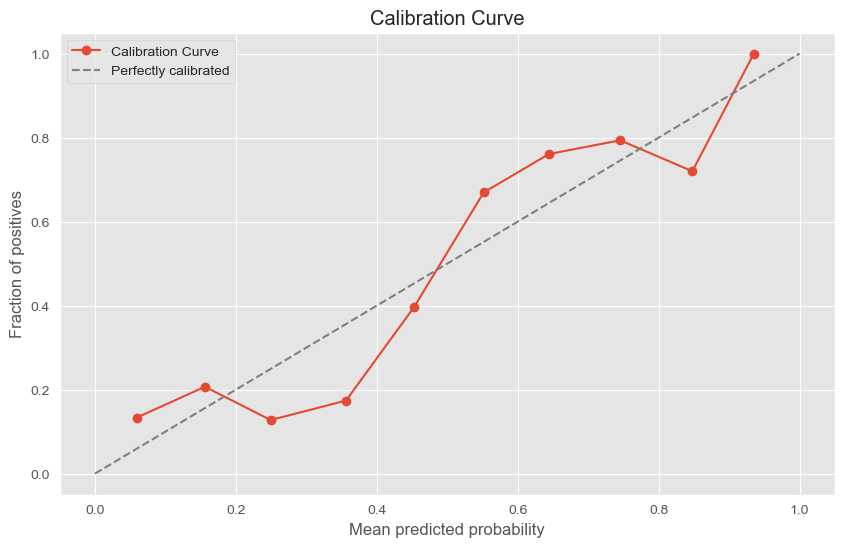

In [38]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, calibrated_svc.predict_proba(test_x)[:, 1], n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()